# U.S. Presidential Election - State Level with Demographic Data

## Libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import requests
import lxml.html as lh

import sys

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

import networkx as nx
import plotly.graph_objects as go

sys.path.append('..')
from lmapper.filter import Projection
from lmapper.filter import Filter

from lmapper.cutoff import FirstGap

from utils import get_node_size, get_mean_node, get_mapper
from filters import SvdFilter, LpFilter
from plotting import nx_plot_mapper

../lmapper/cpp/filterutils


The Python implementation of the eccentricity is used instead, but it will be slower.
The scipy.distance.cdist implementation is used instead.


In [2]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                           ["blue", "violet", "red"])
cmap_inv = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                               ["red", "violet", "blue"])

## Data

In [9]:
df = (pd.read_pickle(os.path.join('data',
                                  'usa_election_full_dataset.pickle'))
      .drop(columns=['county', 'winner', 'fips', 'pres'])
      .groupby(['year', 'state'])
      .sum()
      .dropna()
      .reset_index())
df['winner'] = (df['republican'] > df['democrat']).astype('int')

num_cols = ['Personal income (thousands of dollars)',
            'Net earnings by place of residence',
            'Personal current transfer receipts',
            'Income maintenance benefits 1/',
            'Unemployment insurance compensation',
            'Retirement and other',
            'Dividends, interest, and rent 2/',
            'Population (persons) 3/',
            'Per capita personal income 4/',
            'Per capita net earnings 4/',
            'Per capita personal current transfer receipts 4/',
            'Per capita income maintenance benefits 4/',
            'Per capita unemployment insurance compensation 4/',
            'Per capita retirement and other 4/',
            'Per capita dividends, interest, and rent 4/',
            'Earnings by place of work',
            'Wages and salaries',
            'Supplements to wages and salaries',
            'Employer contributions for employee pension and insurance funds 5/',
            'Employer contributions for government social insurance',
            "Proprietors' income",
            "Farm proprietors' income",
            "Nonfarm proprietors' income",
            'Total employment (number of jobs)',
            'Wage and salary employment',
            'Proprietors employment',
            'Farm proprietors employment 6/',
            'Nonfarm proprietors employment',
            'Average earnings per job (dollars)',
            'Average wages and salaries',
            "Average nonfarm proprietors' income"]

info_cols = ['year', 'state']

elec_cols = ['republican', 'democrat', 'total_votes',
             'winner']

race_cols = ['white', 'black', 'hispanic',
             'asian', 'american indian/alaska native',
             'native hawaiian/other pacific islander',
             'two or more races']

df = df.merge(pd.read_pickle(os.path.join('data',
                                          'us_demo.pickle')),
              on=['year', 'state'],
              how='inner')

df = df[info_cols + elec_cols + race_cols + num_cols]
df.head()

,year,state,republican,democrat,total_votes,winner,white,black,hispanic,asian,...,Farm proprietors' income,Nonfarm proprietors' income,Total employment (number of jobs),Wage and salary employment,Proprietors employment,Farm proprietors employment 6/,Nonfarm proprietors employment,Average earnings per job (dollars),Average wages and salaries,Average nonfarm proprietors' income
0,2008,Alabama,1266546.0,813479.0,2099819.0,1,0.69,0.26,0.03,0.01,...,649336.0,7926772.0,2582591.0,2075014.0,507577.0,41846.0,465731.0,2315177.0,2180875.0,920963.0
1,2008,Arizona,1230111.0,1034707.0,2293475.0,1,0.58,0.03,0.30,0.02,...,164489.0,12825584.0,3402808.0,2706550.0,696258.0,15640.0,680618.0,615109.0,568980.0,281868.0
2,2008,Arkansas,638017.0,422310.0,1086617.0,1,0.76,0.15,0.06,0.01,...,1293949.0,4710266.0,1579283.0,1259243.0,320040.0,43259.0,276781.0,2461330.0,2225313.0,1160377.0
3,2008,California,5011781.0,8274473.0,13561900.0,0,0.42,0.06,0.37,0.12,...,5313632.0,132504105.0,20654292.0,16052090.0,4602202.0,66821.0,4535381.0,2788973.0,2444581.0,1575989.0
4,2008,Colorado,1073589.0,1288576.0,2401361.0,0,0.71,0.03,0.20,0.03,...,421290.0,15291916.0,3251097.0,2474409.0,776688.0,32689.0,743999.0,2275999.0,2271439.0,1113688.0


In [10]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,year,state,republican,democrat,total_votes,winner,white,black,hispanic,asian,...,Farm proprietors' income,Nonfarm proprietors' income,Total employment (number of jobs),Wage and salary employment,Proprietors employment,Farm proprietors employment 6/,Nonfarm proprietors employment,Average earnings per job (dollars),Average wages and salaries,Average nonfarm proprietors' income
0,2008,Alabama,1266546.0,813479.0,2099819.0,1,0.69,0.26,0.03,0.01,...,-0.203832,-0.455379,-0.253448,-0.239764,-0.296560,0.146612,-0.308428,-0.092158,-0.030285,-0.421624
1,2008,Arizona,1230111.0,1034707.0,2293475.0,1,0.58,0.03,0.30,0.02,...,-0.498163,-0.312282,-0.046824,-0.032938,-0.092328,-0.599305,-0.070986,-1.061594,-1.021187,-0.949715
2,2008,Arkansas,638017.0,422310.0,1086617.0,1,0.76,0.15,0.06,0.01,...,0.187486,-0.549336,-0.506195,-0.506927,-0.499553,0.186831,-0.517210,-0.008816,-0.002967,-0.223794
3,2008,California,5011781.0,8274473.0,13561900.0,0,0.42,0.06,0.37,0.12,...,2.627670,3.183613,4.299065,4.337695,4.135535,0.857491,4.188378,0.178017,0.131826,0.119631
4,2008,Colorado,1073589.0,1288576.0,2401361.0,0,0.71,0.03,0.20,0.03,...,-0.342270,-0.240238,-0.085042,-0.108963,-0.005269,-0.114029,-0.000952,-0.114498,0.025389,-0.262373


In [11]:
data = df[df.columns.difference(['year', 'state',
                                 'republican',
                                 'democrat',
                                 'total_votes'])].values

row_years = dict(zip(df['year'].unique(),
                     map(lambda x: df[df['year'] == x].index,
                         df['year'].unique())))

data_per_year = list(map(lambda x: data[x, :], list(row_years.values())))

### Mapper
#### SVD Filter

<hr style="border: 1px dashed rgb(255,255,255)" color=rgb(0,0,0) size="6">

#### Projection

In [17]:
ax = 19

nintervals = 10
overlap = 0.9

method = 'complete'
metric = 'correlation'
cutoff = FirstGap(.4)

filtr = Projection(ax=ax)

##### 2008

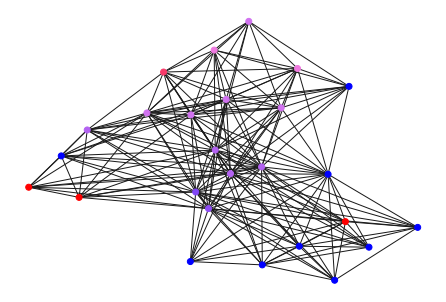

In [18]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[0])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2012

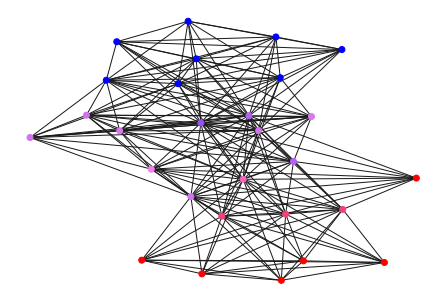

In [19]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[1])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2016

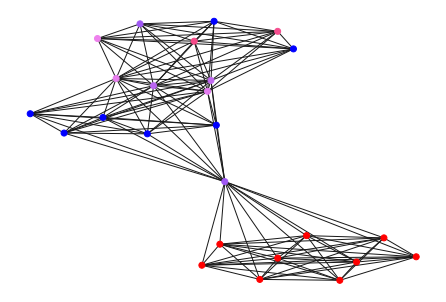

In [20]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[2])
mapper.fit(verbose=0)

nx_plot_mapper(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='winner'),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))